In [34]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error
import xgboost as xgb

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Supuesto

Para el modelo a utilizar, se considerará que las facturas en estado PROCESSING corresponden a las facturas de Octubre, pero no se sabe cuales serán financiadas por Xepelin. En la base de datos se puede obtener el valor total de las facturas en procesos financiadas, el cual se utilizará para contrastar los resultados obtenidos.

## Modelo

Se evaluaron dos enfoques para desarrollar un modelo de predicción:

- Primero se busco predecir dada una factura, cuanto financia Xepelin de esta. Para eso se consideraron como variables del modelo el Id del pagador, el Id del recibidor y el monto de la factura. 

- En el segundo enfoque se consideraró un modelo de series de tiempo, para el cual se agruparon las facturas de acuerdo al mes en el cual fueron pagadas, obteniendo el monto total mensual.


Se obtuvieron ideas de los siguientes articulos:
- https://machinelearningmastery.com/time-series-forecast-study-python-monthly-sales-french-champagne/
- https://towardsdatascience.com/5-machine-learning-techniques-for-sales-forecasting-598e4984b109



### Primer Enfoque

In [4]:
path = "drive/My Drive/Xepelin/data_test2.csv"
df = pd.read_csv(path)
df.head()

,PayerId,ReceiverId,invoiceId,paidAt,amount,amountfinancedByXepelin,status
0,53,10,18660729,8/23/21 00:00,1490.46,0.00,PAID
1,93,11,18660730,3/22/21 00:00,6418.28,624.48,PAID
2,122,12,18660731,2/18/21 00:00,27979.20,10520.15,PAID
3,85,13,18660732,3/15/21 00:00,183070.77,79421.63,PAID
4,87,14,18660733,7/23/21 00:00,20532.00,20532.00,PAID


In [5]:
df['month'] = pd.DatetimeIndex(df['paidAt']).month
df.head()

,PayerId,ReceiverId,invoiceId,paidAt,amount,amountfinancedByXepelin,status,month
0,53,10,18660729,8/23/21 00:00,1490.46,0.00,PAID,8.0
1,93,11,18660730,3/22/21 00:00,6418.28,624.48,PAID,3.0
2,122,12,18660731,2/18/21 00:00,27979.20,10520.15,PAID,2.0
3,85,13,18660732,3/15/21 00:00,183070.77,79421.63,PAID,3.0
4,87,14,18660733,7/23/21 00:00,20532.00,20532.00,PAID,7.0


Se realiza el Split de los datos. Para esto, primero se sacan los datos con el status de Processing que representa a las facturas de Octubre, las cuales serán utilizados después para obtener la predicción final. El resto de los datos se seperan en un set de entrenamiento y otro de validación.

In [30]:
mask = df['status'] == 'PROCESSING'
df_proc = df[mask]
df_train = df[~mask]
X = df_train[['amount','PayerId','ReceiverId']]
y = df_train['amountfinancedByXepelin']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)

In [50]:
rf = RandomForestRegressor(n_estimators=100, max_depth=5)
rf.fit(X_train,y_train)
xgb_model = xgb.XGBRegressor(n_estimators=60)
xgb_model.fit(X_train,y_train)

[15:52:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_estimators=60)

Resultados Random Forest

In [44]:
y_hat_train = rf.predict(X_train)
y_hat_test = rf.predict(X_test)
error = np.abs(y_test - y_hat_test)
print("Error absoluto promedio Train: {}".format(mean_absolute_error(y_train, y_hat_train)))
print("Error absoluto promedio Test: {}".format(mean_absolute_error(y_test, y_hat_test)))

Error absoluto promedio Train: 8291.46130582764
Error absoluto promedio Test: 8525.046646826737


Resultados Xgboost

In [51]:
y_hat_train = xgb_model.predict(X_train)
y_hat_test = xgb_model.predict(X_test)
error = np.abs(y_test - y_hat_test)
print("Error absoluto promedio Train: {}".format(mean_absolute_error(y_train, y_hat_train)))
print("Error absoluto promedio Test: {}".format(mean_absolute_error(y_test, y_hat_test)))

Error absoluto promedio Train: 6422.853171839559
Error absoluto promedio Test: 8904.17185648709


In [40]:
df_octubre = df_proc[['amount','PayerId','ReceiverId']]
res1 = rf.predict(df_octubre)
res2 = xgb_model.predict(df_octubre)
amount = df_proc['amount'].sum()
Xamount = df_proc['amountfinancedByXepelin'].sum()
print(f'Dinero que se movera en Xepelin en Octubre: {Xamount}')
print(f'La predicción con random forest del dinero que se moverá en el mes de Octubre es: {res1.sum()}')
print(f'La predicción con random forest del dinero que se moverá en el mes de Octubre es: {res2.sum()}')

Dinero que se movera en Xepelin en Octubre: 2011202.9999999998
La predicción con random forest del dinero que se moverá en el mes de Octubre es: 2123475.9938999997
La predicción con random forest del dinero que se moverá en el mes de Octubre es: 1849498.125


### Segundo Enfoque

Primero, se construye la base de datos agrupando las transacciones por mes.

In [6]:
df_meses = df.groupby(by=['month']).agg({'amountfinancedByXepelin':'sum','amount':'sum','status':'count'}).reset_index()
df_meses.rename(columns={'status':'count'},inplace=True)
df_meses['Ratio'] = df_meses['amountfinancedByXepelin']/df_meses['amount']
df_meses

,month,amountfinancedByXepelin,amount,count,Ratio
0,2.0,10520.15,34425.18,4,0.305595
1,3.0,119352.51,269826.65,14,0.442330
2,4.0,592831.07,753946.49,17,0.786304
3,5.0,5187188.89,7250723.28,106,0.715403
4,6.0,4518034.66,7132982.75,184,0.633400
5,7.0,2344379.98,5765920.25,225,0.406593
6,8.0,3057870.38,5044795.41,271,0.606144
7,9.0,714735.77,1178392.90,71,0.606534


In [7]:
data = df_meses[['month','amountfinancedByXepelin','Ratio']]
data['dif'] = data.amountfinancedByXepelin.diff()
data['ratio_dif'] = data.Ratio.diff()
data2 = data.dropna()    
data.head(11)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,month,amountfinancedByXepelin,Ratio,dif,ratio_dif
0,2.0,10520.15,0.305595,NaN,NaN
1,3.0,119352.51,0.442330,108832.36,0.136736
2,4.0,592831.07,0.786304,473478.56,0.343974
3,5.0,5187188.89,0.715403,4594357.82,-0.070901
4,6.0,4518034.66,0.633400,-669154.23,-0.082002
5,7.0,2344379.98,0.406593,-2173654.68,-0.226808
6,8.0,3057870.38,0.606144,713490.40,0.199551
7,9.0,714735.77,0.606534,-2343134.61,0.000391


Un factor importante para realizar un modelo de series de tiempo es que los datos sean estacionarios. Para esto se puede realizar un Dickey-Fuller test, utilizando el metodo *adfuller* de la libreria statsmodels.

Existen 3 variables que pueden ser utiles para realizar un modelo: 
- El total financiado por Xepelin cada mes.
- La diferencia entre lo que financió Xepelin el mes actual y el mes anterior.
- La proporción entre lo financiado por Xepelin y el total de las facturas transadas en ese mes (Columna 'Ratio').

A continuación se realiza el test para estas 3 opciones respectivamente.

In [9]:
test = adfuller(data['amountfinancedByXepelin'])
print('ADF Statistic: %f' % test[0])
print('p-value: %f' % test[1])
print('Critical Values:')
for key, value in test[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.304774
p-value: 0.170433
Critical Values:
	1%: -6.045
	5%: -3.929
	10%: -2.987


In [10]:
test = adfuller(data2['dif'])
print('ADF Statistic: %f' % test[0])
print('p-value: %f' % test[1])
print('Critical Values:')
for key, value in test[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.985542
p-value: 0.292948
Critical Values:
	1%: -5.354
	5%: -3.646
	10%: -2.901


In [11]:
test = adfuller(data['Ratio'])
print('ADF Statistic: %f' % test[0])
print('p-value: %f' % test[1])
print('Critical Values:')
for key, value in test[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -10.261907
p-value: 0.000000
Critical Values:
	1%: -6.045
	5%: -3.929
	10%: -2.987


De los resultados anteriores, se concluye que solo el último test rechaza la hipótesis nula, dado que el valor del estadistico es menor que los valores críticos para los 3 niveles de significancia. Esto permite concluir que para esta base de datos, la razón entre lo financiado por Xepelin y la suma de las facturas transadas en ese mes son datos estacionarios en el tiempo.


Para la definición del modelo, se evaluó utilizar algoritmos supervisados tales como Random forest o Xgboost generando atributos a partir de la diferencia entre los ultimos meses. Un ejemplo de como se vería el dataframe con los datos se muestra a continuación.

In [13]:
data_reg = df_meses[['month','amountfinancedByXepelin','amount']]
data_reg['dif'] = data_reg.amountfinancedByXepelin.diff()
for i in range(1,4):
  column = f'shift_{i}'
  data_reg[column] = data_reg['dif'].shift(i)
data_reg.dropna(inplace=True)
data_reg.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,month,amountfinancedByXepelin,amount,dif,shift_1,shift_2,shift_3
4,6.0,4518034.66,7132982.75,-669154.23,4594357.82,473478.56,108832.36
5,7.0,2344379.98,5765920.25,-2173654.68,-669154.23,4594357.82,473478.56
6,8.0,3057870.38,5044795.41,713490.40,-2173654.68,-669154.23,4594357.82
7,9.0,714735.77,1178392.90,-2343134.61,713490.40,-2173654.68,-669154.23


Sin embargo, dado que la base de datos cuenta con pocos meses, serían muy pocos datos para el entrenamiento y existiría overfitting. Por esta razón, se prefirió utilizar un modelo ARIMA utilizando el Ratio (dado que es la única columna estacionaria). A continuación se utiliza el modelo y se realizan las estimaciones.

In [14]:
model = ARIMA(data['Ratio'], order=(2,0,1))
results = model.fit(disp=-1)

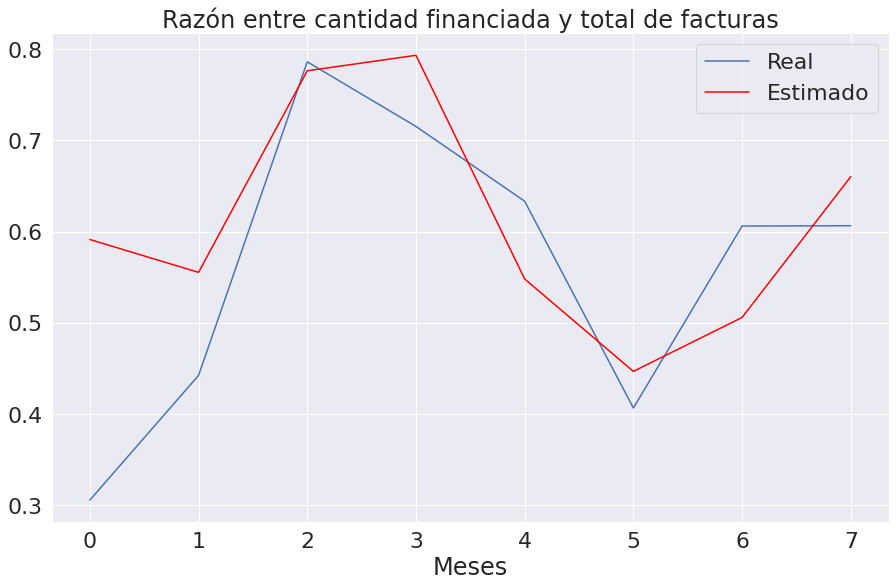

In [15]:
sns.set(font_scale=2)
fig = plt.figure(figsize=(15,9))
plt.plot(data['Ratio'],label='Real')
plt.plot(results.fittedvalues, color='red',label='Estimado')
plt.xlabel('Meses')
plt.title('Razón entre cantidad financiada y total de facturas')
plt.legend()

En el gráfico se muestran las proporciones reales y estimadas para cada mes. Debemos considerar que el mes 0 corresponde a Febrero y el mes 7 a Septiembre. Luego, se puede obtener la predicción para el mes de Octubre.

In [16]:
df_proc = df[df['status']=='PROCESSING']
amount = df_proc['amount'].sum()
Xamount = df_proc['amountfinancedByXepelin'].sum()
print(f'Dinero que se movera en Xepelin en Octubre: {Xamount}')
print(f'Proporción de monto auspiciado por Xepelin y total de facturas para facturas en estado PROCESSING: {Xamount/amount}')
print('--------------------------------------------------------------------------')
print(f'La proporción para el mes de Octubre es: {results.predict(0,8)[8]}')
print(f'La predicción del dinero que se moverá en el mes de Octubre es: {results.predict(0,8)[8]*amount}')

Dinero que se movera en Xepelin en Octubre: 2011202.9999999998
Proporción de monto auspiciado por Xepelin y total de facturas para facturas en estado PROCESSING: 0.5949225107782067
--------------------------------------------------------------------------
La proporción para el mes de Octubre es: 0.6404476158041993
La predicción del dinero que se moverá en el mes de Octubre es: 2165105.7791767754


Si bien el modelo ARIMA tendría un mejor desempeño con un historial más grande, logra acercarse bastante a los valores reales del dinero que se mueve por parte de Xepelin mensualmente. 